In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")
from itertools import product, combinations
from random import sample

In [2]:
cards = [p for p in product([1,2,3,4,5,6,7,10,11,12], [0,1,2,3])]
print len(cards)

40


In [3]:
def score(c):
    if c>=10:
        return 0
    else:
        return c
    
def piece(c, show, envy = True):
    d = {2:30,4:29,5:28,11:27,10:27}
    pieces = [2,4,5,11,10]
    if c[0] in pieces and c[1] == show[1]:
        if envy:
            return d[c[0]]
        else:
            return True
    elif show[0] in [2,4,5,11,10] and c[0] == 12 and c[1] == show[1]:
        if envy:
            return d[show[0]]
        else:
            return True
    else:
        if envy:
            return score(c[0])
        else:
            return False
        
def flower(hand,show):
    pieces = sum([piece(h, show, envy=False) for h in hand])
    if pieces == 0:
        suits = len(set([suit for val, suit in hand]))
        if suits == 1:
            return True
        else:
            return False
    elif pieces == 1:
        suits = len(set([c[1] for c in hand if piece(c, show, envy=False) == False]))
        if suits == 1:
            return True
        else:
            return False
    else:
        return True
    
def scorer(c1, c2, show):
    p1 = piece(c1, show, envy = False)
    p2 = piece(c2, show, envy = False)
    if p1 or p2:
        return piece(c1, show) + piece(c2, show)
    else:
        if c1[1] == c2[1]:
            return 20+score(c1[0]) + score(c2[0])
        else:
            return score(c1[0]) + score(c2[0])
        
def sims_to_dict(envies, summary = False):
    d = {}
    for e in envies:
        if len(set(zip(*e)[0])) != 4:
            e_new = [(p-(i+1)/float(100),i) for p, i in e]
        else:
            e_new = e
        t1_m = 0
        t2_m = 0
        for e_, i in e_new:
            if i % 2 and e_ > t1_m:
                t1_m = e_
            elif (i % 2 == 0) and e_ > t2_m: 
                t2_m = e_
        for e_, i in e_new:
            ind = 0
            if i % 2 and e_ > t2_m:
                ind = 1
            elif (i % 2 == 0) and e_ > t1_m:
                ind = 1
            try:
                d[int(round(e_))].append((i, ind))
            except KeyError:
                d[int(round(e_))] = [(i, ind)]
    d_ = {}
    for k, v in d.iteritems():
        d_[k] = parse_truco(v)
    if summary:
        return {k : {k_ : (sum(v_)/float(len(v_)), len(v_)) for k_, v_ in v.iteritems()} for k, v in d_.iteritems()}
    else:
        return d_
    
def simmer(nsims, deck, players):
    vals = [0] * nsims
    for i in range(nsims):
        draw = sample(cards, 1+3*players)
        show = draw[0]
        hand1 = draw[1:4]
        hand2 = draw[4:7]
        hand3 = draw[7:10]
        hand4 = draw[10:13]
        #hand5 = draw[13:16]
        #hand6 = draw[16:]
        try:
            envies = []
            for p in range(players):
                hand = draw[1+3*p:1+3*(p+1)]
                envies.append((max([scorer(c1, c2, show) for c1, c2 in combinations(hand, 2) if flower(hand, show) == False]),p))
            vals[i] = envies
        except ValueError:
            vals[i] = -1
    final = [item for item in vals if item != -1]
    return final

def parse_truco(v):
    d = {}
    for h in v:
        place = h[0]
        ind = h[1]
        try:
            d[place].append(ind)
        except KeyError:
            d[place] = [ind]
    return d    

In [4]:
%%time
nsims = 1000000
four_people = simmer(nsims, cards, 4)
six_people = simmer(nsims, cards, 4)
print 1-len(four_people)/float(nsims)
print 1-len(six_people)/float(nsims)

0.500524
0.501271
Wall time: 3min 21s


In [5]:
%%time
d_four = sims_to_dict(four_people, summary=True)
d_four_ = sims_to_dict(four_people)
d_six = sims_to_dict(four_people, summary=True)
d_six_ = sims_to_dict(six_people)

Wall time: 14.6 s


In [6]:
d_four

{0: {0: (0.0, 2459), 1: (0.0, 2415), 2: (0.0, 2395), 3: (0.0, 2436)},
 1: {0: (0.0005399568034557236, 3704),
  1: (0.0, 3730),
  2: (0.0, 3738),
  3: (0.0, 3710)},
 2: {0: (0.0, 4089), 1: (0.0, 4110), 2: (0.0, 3926), 3: (0.0, 4105)},
 3: {0: (0.00076103500761035, 6570),
  1: (0.0, 6366),
  2: (0.00015309246785058175, 6532),
  3: (0.00015039855617386073, 6649)},
 4: {0: (0.000972087210109707, 7201),
  1: (0.00041333700744006614, 7258),
  2: (0.001384083044982699, 7225),
  3: (0.0001414227124876255, 7071)},
 5: {0: (0.002838006584175275, 8809),
  1: (0.0018283624728602445, 8751),
  2: (0.0018105691976915243, 8837),
  3: (0.0011295606009262397, 8853)},
 6: {0: (0.00480890913692736, 11853),
  1: (0.004140611796518506, 11834),
  2: (0.003722504230118443, 11820),
  3: (0.003055249087668675, 11783)},
 7: {0: (0.011872526556967298, 14403),
  1: (0.00856140350877193, 14250),
  2: (0.007555982964692952, 14558),
  3: (0.006676204101096805, 14679)},
 8: {0: (0.01801930639971398, 13985),
  1: (0.01

In [7]:
d_six

{0: {0: (0.0, 2459), 1: (0.0, 2415), 2: (0.0, 2395), 3: (0.0, 2436)},
 1: {0: (0.0005399568034557236, 3704),
  1: (0.0, 3730),
  2: (0.0, 3738),
  3: (0.0, 3710)},
 2: {0: (0.0, 4089), 1: (0.0, 4110), 2: (0.0, 3926), 3: (0.0, 4105)},
 3: {0: (0.00076103500761035, 6570),
  1: (0.0, 6366),
  2: (0.00015309246785058175, 6532),
  3: (0.00015039855617386073, 6649)},
 4: {0: (0.000972087210109707, 7201),
  1: (0.00041333700744006614, 7258),
  2: (0.001384083044982699, 7225),
  3: (0.0001414227124876255, 7071)},
 5: {0: (0.002838006584175275, 8809),
  1: (0.0018283624728602445, 8751),
  2: (0.0018105691976915243, 8837),
  3: (0.0011295606009262397, 8853)},
 6: {0: (0.00480890913692736, 11853),
  1: (0.004140611796518506, 11834),
  2: (0.003722504230118443, 11820),
  3: (0.003055249087668675, 11783)},
 7: {0: (0.011872526556967298, 14403),
  1: (0.00856140350877193, 14250),
  2: (0.007555982964692952, 14558),
  3: (0.006676204101096805, 14679)},
 8: {0: (0.01801930639971398, 13985),
  1: (0.01

In [8]:
hist_4 = {k : sum([len(v__) for _, v__ in v.iteritems()])/float(nsims) for k, v in d_four_.iteritems()}
#print hist_4
hist_6 = {k : sum([len(v__) for _, v__ in v.iteritems()])/float(nsims) for k, v in d_six_.iteritems()}
#print hist_6

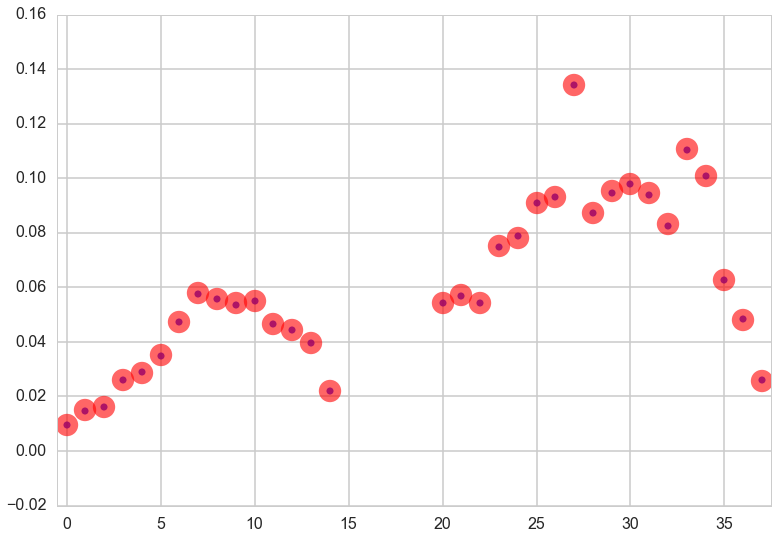

In [10]:
sns.regplot(y = np.array(hist_6.values()), x = np.array(hist_6.keys()), fit_reg=False, scatter_kws={'s' : 50, 'color' : 'b'})
sns.regplot(y = np.array(hist_4.values()), x = np.array(hist_4.keys()), fit_reg=False, scatter_kws={'s' : 500, 'color' : 'r', 'alpha' : .6})
plt.xlim([-.5, 37.5]);